# Export sensivity results
- This script is used to export model sensivity simulation results;
- BASE, SENS;

In [29]:
import os
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cftime
import string

In [43]:
path = '/mnt/iusers01/fatpou01/sees01/a16404ys/scratch/'
archive = '/Projects/archive/0project2/'
psites = ["AU-Preston","US-Baltimore","US-WestPhoenix"]
msites = ["AU-Pre","US-Bal","US-Wes"]
var1 = ['SWup', 'LWup', 'Qh', 'Qle', 'Qtau']
var2 = ['FSR', 'FIRE_U', 'FSH_U', 'EFLX_LH_TOT_U', 'TAUX']
#file_date = ['2004-05-18', '2009-04-04', '2012-03-08']
#start_date = ['2004-05-18T00:00:00', '2009-04-04T00:00:00','2012-03-08T00:00:00']
#end_date = ['2004-05-25T23:30:00', '2009-04-11T23:30:00', '2012-03-15T23:30:00']
file_date = ['2004-05-18', '2006-12-05', '2012-12-24']
start_date = ['2004-05-18T00:00:00', '2006-12-05T02:00:00','2012-12-24T00:00:00']
end_date = ['2004-05-25T23:30:00', '2006-12-12T01:00:00', '2012-12-31T23:30:00']
ahf = []
subset_list = ['morp', 'radi', 'ther', 'temp']
#subset_list = ['temp']
index_length = [65, 257, 65, 9]
#index_length = [9]
hour = ['01800', '07200', '01800']

In [44]:
def calculate_metrics(observed_valid, *simulated):
    metrics = []
    for sim_data_valid in simulated:
        
        # Standard deviation
        std = float(np.std(sim_data_valid))
        sdev = std/float(np.std(observed_valid))
        
        # Correlation coefficient
        coef = float(xr.corr(xr.DataArray(observed_valid), xr.DataArray(sim_data_valid)).values)

        metrics.append((sdev, coef))
        
    return metrics

In [62]:
# read four subset results
all_results = []
for subset, label in enumerate(subset_list):
    for sitesequence in range(len(psites)):
    #for sitesequence in [1]:
        GRIDNAME = psites[sitesequence]
        GRIDNAME_single = msites[sitesequence]
        start_time = start_date[sitesequence]
        end_time = end_date[sitesequence]
        observation = path + 'UrbanPlumber/Urban-PLUMBER_FullCollection_v1/' + GRIDNAME + '/timeseries/'+ GRIDNAME + '_clean_observations_v1.nc'
        ds_ob = xr.open_dataset(observation)
        sliced_ds_ob = ds_ob.sel(time=slice(start_time, end_time))[var1]
        df_ob = sliced_ds_ob.to_dataframe().reset_index()
        df_ob = df_ob.rename(columns={'SWup': 'SWup_obs', 'LWup': 'LWup_obs',
                                      'Qh': 'Qh_obs', 'Qle': 'Qle_obs', 
                                      'Qtau': 'Qtau_obs'})
        # change the nan upward solar radition to 0 in observation data
        df_ob['SWup_obs'] = df_ob['SWup_obs'].fillna(0)
        
        for index in range(index_length[subset]):
            if index ==index_length[subset]-1: # baseline
                sens = path + archive + '0sp/' + GRIDNAME_single + '_sen_base/lnd/hist/' + GRIDNAME_single + '_sen_base.clm2.h0.' + file_date[sitesequence] +'-' + hour[sitesequence] + '.nc'
                ds_sens = xr.open_dataset(sens)
            else:    
                sens = path + archive + '0sensitivity/' + GRIDNAME_single + '_sen_' + label + '/' + GRIDNAME_single + '_sen_' + label + '.clm2.h0.' + file_date[sitesequence] +'-' + hour[sitesequence] + '_' + str(index) + '.nc'
                ds_sens = xr.open_dataset(sens)
                ds_sens['time']=ds_sens['time'].dt.round('min')
                ds_sens['time']=ds_sens['time'].dt.ceil('min')
    
            sliced_ds_sens = ds_sens.sel(time=slice(start_time, end_time))[var2]
            df_sens = sliced_ds_sens.to_dataframe().reset_index()
            df_sens.drop(columns=['lndgrid'], inplace=True)
            df_sens = df_sens.rename(columns={'FSR': 'SWup_lcz', 'FIRE_U': 'LWup_lcz', 
                                              'FSH_U': 'Qh_lcz', 'EFLX_LH_TOT_U': 'Qle_lcz', 'TAUX': 'Qtau_lcz'})
            df_sens['Qtau_lcz'] = - df_sens['Qtau_lcz']
        
            df = pd.merge(df_ob, df_sens, on='time')
            df.loc[df['SWup_obs'].isna(), ['SWup_lcz']] = np.nan
            df.loc[df['LWup_obs'].isna(), ['LWup_lcz']] = np.nan
            df.loc[df['Qh_obs'].isna(), ['Qh_lcz']] = np.nan
            df.loc[df['Qle_obs'].isna(), ['Qle_lcz']] = np.nan
            df.loc[df['Qtau_obs'].isna(), ['Qtau_lcz']] = np.nan
            results = []
            for var_index in range(len(var1)):
                var_obs = var1[var_index] + '_obs'
                var_sens = var1[var_index] + '_lcz' 
                metrics = calculate_metrics(df[var_obs], df[var_sens])
        
                for j, (sdev, coef) in enumerate(metrics):
                    results.append({'Variable': var1[var_index],'Index': index,'Type':label,
                                'sdev': sdev,'coef': coef,'site': GRIDNAME})
            
            all_results.extend(results) 
results_df = pd.DataFrame(all_results)
output_dir = '/mnt/iusers01/fatpou01/sees01/a16404ys/scratch/output_analysis/project2/sp_sensitivity/taylor_diagram/'
results_df.to_csv(output_dir + 'result.csv', index = False)
results_df

,Variable,Index,Type,sdev,coef,site
0,SWup,0,morp,1.100191,0.997359,AU-Preston
1,LWup,0,morp,1.177265,0.974246,AU-Preston
2,Qh,0,morp,0.748667,0.927966,AU-Preston
3,Qle,0,morp,0.536699,0.436427,AU-Preston
4,Qtau,0,morp,0.233464,0.870784,AU-Preston
...,...,...,...,...,...,...
5935,SWup,8,temp,0.965178,0.997931,US-WestPhoenix
5936,LWup,8,temp,0.982153,0.996330,US-WestPhoenix
5937,Qh,8,temp,0.829161,0.926568,US-WestPhoenix
5938,Qle,8,temp,0.249344,0.536711,US-WestPhoenix


# Description

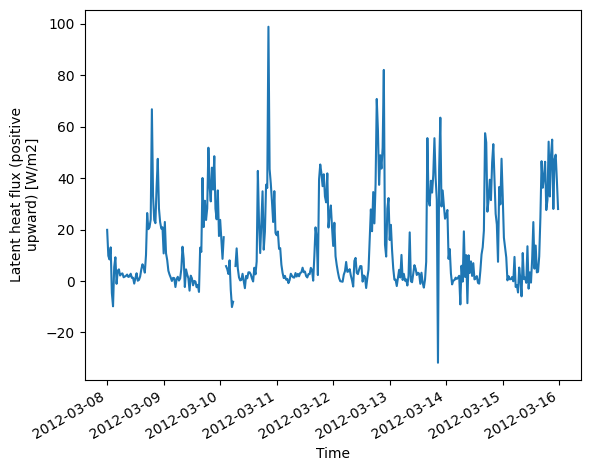

In [81]:
sliced_ds_ob['Qle'].plot()

In [98]:
sens = path + archive + '0sp/' + GRIDNAME_single + '_sen_base/lnd/hist/' + GRIDNAME_single + '_sen_base.clm2.h0.' + file_date[sitesequence] +'-01800.nc'
ds_sens = xr.open_dataset(sens).sel(time=slice(start_time, end_time))[var2]
ds_sens['time']=ds_sens['time'].dt.round('min')
ds_sens['time']=ds_sens['time'].dt.ceil('min')

In [86]:
label = subset_list[2]
sens1 = path + archive + '0sensitivity/' + GRIDNAME_single + '_sen_' + label + '/' + GRIDNAME_single + '_sen_' + label + '.clm2.h0.' + file_date[sitesequence] +'-01800_' + str(index-2) + '.nc'
ds_sens1 = xr.open_dataset(sens1).sel(time=slice(start_time, end_time))[var2]
ds_sens1['time']=ds_sens1['time'].dt.round('min')
ds_sens1['time']=ds_sens1['time'].dt.ceil('min')

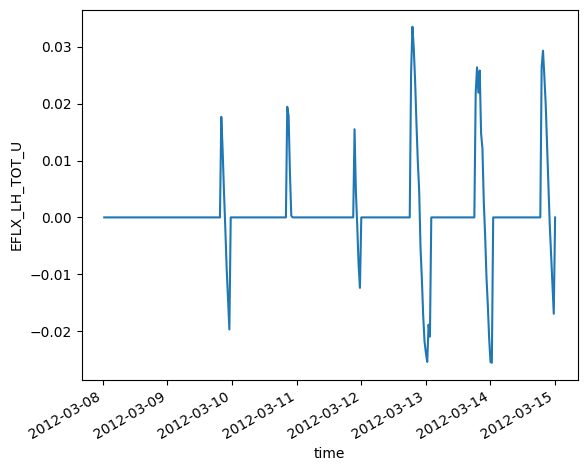

In [87]:
(ds_sens['EFLX_LH_TOT_U']-ds_sens1['EFLX_LH_TOT_U']).plot()

In [88]:
difference = ds_sens['EFLX_LH_TOT_U'] - ds_sens1['EFLX_LH_TOT_U']

# Find the index of the maximum difference
index_max = difference.argmin()

# Convert the index to coordinates
coords_max = difference.coords['time'][index_max]

max_difference = difference.sel(time=coords_max)

# Print the result
print("Maximum difference:", max_difference)
print("Time of maximum difference:", coords_max)

Maximum difference: <xarray.DataArray 'EFLX_LH_TOT_U' (lndgrid: 1)>
array([-0.02556902], dtype=float32)
Coordinates:
    time     datetime64[ns] 2012-03-14T00:30:00
Dimensions without coordinates: lndgrid
Time of maximum difference: <xarray.DataArray 'time' ()>
array('2012-03-14T00:30:00.000000000', dtype='datetime64[ns]')
Coordinates:
    time     datetime64[ns] 2012-03-14T00:30:00
Attributes:
    long_name:  time
    bounds:     time_bounds


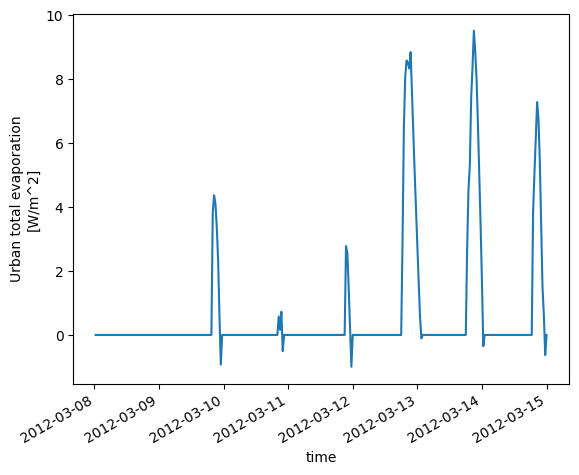

In [89]:
ds_sens1['EFLX_LH_TOT_U'].plot()

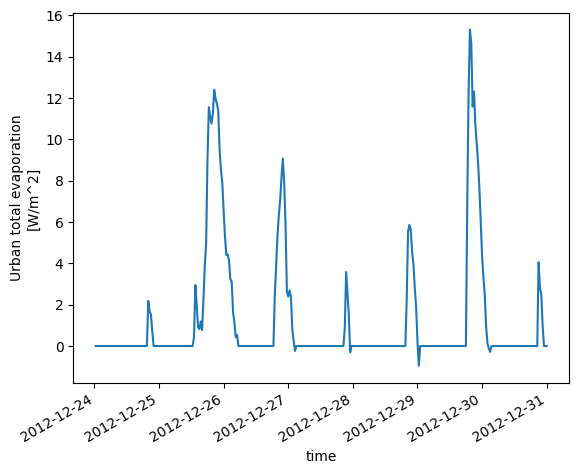

In [105]:
ds_sens['EFLX_LH_TOT_U'].plot()

In [100]:
print(sens)

/mnt/iusers01/fatpou01/sees01/a16404ys/scratch//Projects/archive/0project2/0sp/US-Wes_sen_base/lnd/hist/US-Wes_sen_base.clm2.h0.2012-03-08-01800.nc
